In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder


class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.weights = [np.random.randn(layers[i], layers[i+1]) for i in range(len(layers)-1)]
        self.biases = [np.zeros((1, layers[i+1])) for i in range(len(layers)-1)]
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def forward_pass(self, X):
        activations = [X]
        for w, b in zip(self.weights, self.biases):
            z = np.dot(activations[-1], w) + b
            activations.append(self.sigmoid(z))
        return activations
    
    def backward_pass(self, X, Y, activations):
        deltas = [(activations[-1] - Y) * self.sigmoid_derivative(activations[-1])]
        for i in range(len(self.layers) - 2, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.sigmoid_derivative(activations[i])
            deltas.insert(0, delta)
        return deltas
    
    
    def compute_gradients(self, activations, deltas):
        gradients_weights = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.layers) - 1)]
        gradients_biases = [np.sum(deltas[i], axis=0) for i in range(len(self.layers) - 1)]
        return gradients_weights, gradients_biases
    
    def update_weights(self, gradients_weights, gradients_biases, learning_rate):
        self.weights = [w - learning_rate * gw for w, gw in zip(self.weights, gradients_weights)]
        self.biases = [b - learning_rate * gb for b, gb in zip(self.biases, gradients_biases)]
    
    def train(self, X, Y, learning_rate, lam, max_iterations, epsilon):
        for iteration in range(max_iterations):
            activations = self.forward_pass(X)
            deltas = self.backward_pass(X, Y, activations)
            gradients_weights, gradients_biases = self.compute_gradients(activations, deltas)
            self.update_weights(gradients_weights, gradients_biases, learning_rate)
            # Compute cost function
            J = np.mean(np.square(activations[-1] - Y))
            #print(f"Iteration {iteration+1}, Cost: {J}")
            # Check for convergence
            if J < epsilon:
                #print(f"Converged at cost :{J} while Epsilon:{epsilon} ")
                return J
        return J
            

    def accuracy(self, y_true, y_pred):
        correct = np.sum(np.all(y_true == y_pred, axis=1))
        return correct / len(y_true)


    def f1_score(self, y_true, y_pred):
        tp = np.sum(np.logical_and(y_true, y_pred))
        fp = np.sum(np.logical_and(np.logical_not(y_true), y_pred))
        fn = np.sum(np.logical_and(y_true, np.logical_not(y_pred)))
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return f1


    def evaluate(self, X_test, y_test, J):
        activations = self.forward_pass(X_test)[-1]
        y_pred = (activations > 0.5).astype(int)
        acc = self.accuracy(y_test, y_pred)
        f1 = self.f1_score(y_test, y_pred)
        return J, acc, f1
    
    def k_fold_cross_validation(X, y, architectures, regularization_params, learning_rate, max_iterations, epsilon):
        results_accuracy = {}
        results_f1_score = {}
        results_J_cost = {}
        
        num_splits = 10
        fold_size = len(X) // num_splits

        for arch in architectures:
            for lam in regularization_params:
                accuracy_list = []
                f1_score_list = []
                J_list = []
                
                for i in range(num_splits):
                    start = i * fold_size
                    end = (i + 1) * fold_size
                    
                    X_train = pd.concat([X[:start], X[end:]])
                    y_train = np.concatenate([y[:start], y[end:]])
                    X_test = X[start:end]
                    y_test = y[start:end]

                    mean = np.mean(X_train, axis=0)
                    std = np.std(X_train, axis=0)
                    X_train_normalized = (X_train - mean) / std
                    X_test_normalized = (X_test - mean) / std

                    model = NeuralNetwork(arch)
                    J = model.train(X_train_normalized, y_train, learning_rate=learning_rate, lam=lam, max_iterations=max_iterations, epsilon=epsilon)
                    J, accuracy, f1_score = model.evaluate(X_test_normalized, y_test, J)
                    accuracy_list.append(accuracy)
                    f1_score_list.append(f1_score)
                    J_list.append(J)

                mean_accuracy = np.mean(accuracy_list)
                mean_f1_score = np.mean(f1_score_list)
                mean_J_cost   = np.mean(J_list)

                results_accuracy[(str(arch), lam)] = mean_accuracy
                results_f1_score[(str(arch), lam)] = mean_f1_score
                results_J_cost[(str(arch), lam)] = mean_J_cost

        return results_accuracy, results_f1_score, results_J_cost

#Load dataset
data_file = "/Users/noshitha/Downloads/contraceptive+method+choice/cmc.data"
column_names = [
    "Wife_age", "Wife_education", "Husband_education", "Number_of_children_ever_born",
    "Wife_religion", "Wife_working", "Husband_occupation", "Standard-of-living_index",
    "Media_exposure", "Contraceptive_method_used"
]
cmc_df = pd.read_csv(data_file, names=column_names) 

# Extract features and target variable
X_cmc = pd.get_dummies(cmc_df.drop(columns=['Contraceptive_method_used']))  # Features
y_cmc = cmc_df['Contraceptive_method_used']  

# Re-size data
y_cmc_resized = y_cmc.values.reshape(-1, 1)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the target variable
y_encoded = encoder.fit_transform(y_cmc_resized)

# Define model architectures and regularization parameters
architectures = [
    [X_cmc.shape[1], 30, 25, y_encoded.shape[1]], 
    [X_cmc.shape[1], 20, 15, 10, 5, y_encoded.shape[1]],
    [X_cmc.shape[1], 25, 20, 15, 10, y_encoded.shape[1]],
    [X_cmc.shape[1], 60, 80, 70, y_encoded.shape[1]],  
    [X_cmc.shape[1], 80, 60, 40, 30, y_encoded.shape[1]],    
    [X_cmc.shape[1], 70, 80, 60, 70, y_encoded.shape[1]], 
    [X_cmc.shape[1], 120, 100, 80, 60, 40, y_encoded.shape[1]],
    [X_cmc.shape[1], 150, 120, 100, 110, 130, 140, y_encoded.shape[1]]
]

regularization_params = [0.000001, 0.00001, 0.001]

# Initialize lists to store results
results_accuracy = {}
results_f1_score = {}
results_J_cost = {}

# Perform stratified k-fold cross-validation
results_accuracy, results_f1_score, results_J_cost = NeuralNetwork.k_fold_cross_validation(X_cmc, y_encoded, architectures, regularization_params, learning_rate=0.0001, max_iterations=2500, epsilon=0.005)

# Convert the results into a DataFrame for tabular representation
accuracy_df = pd.DataFrame(list(results_accuracy.items()), columns=['Architecture, Lambda', 'Mean Accuracy'])
f1_score_df = pd.DataFrame(list(results_f1_score.items()), columns=['Architecture, Lambda', 'Mean F1 Score'])
J_cost_df = pd.DataFrame(list(results_J_cost.items()), columns=['Architecture, Lambda', 'Mean J Cost'])

print("Mean Accuracy Results:")
print(accuracy_df)
print("\nMean F1 Score Results:")
print(f1_score_df)
print("\nMean J cost Results:")
print(J_cost_df)

Mean Accuracy Results:
                             Architecture, Lambda  Mean Accuracy
0                         ([9, 30, 25, 3], 1e-06)       0.219048
1                         ([9, 30, 25, 3], 1e-05)       0.191837
2                         ([9, 30, 25, 3], 0.001)       0.217007
3                  ([9, 20, 15, 10, 5, 3], 1e-06)       0.006803
4                  ([9, 20, 15, 10, 5, 3], 1e-05)       0.027891
5                  ([9, 20, 15, 10, 5, 3], 0.001)       0.025170
6                 ([9, 25, 20, 15, 10, 3], 1e-06)       0.114966
7                 ([9, 25, 20, 15, 10, 3], 1e-05)       0.155782
8                 ([9, 25, 20, 15, 10, 3], 0.001)       0.144218
9                     ([9, 60, 80, 70, 3], 1e-06)       0.240816
10                    ([9, 60, 80, 70, 3], 1e-05)       0.264626
11                    ([9, 60, 80, 70, 3], 0.001)       0.278912
12                ([9, 80, 60, 40, 30, 3], 1e-06)       0.255102
13                ([9, 80, 60, 40, 30, 3], 1e-05)       0.242177
14

In [9]:
# Merge accuracy and f1_score DataFrames on 'Architecture, Lambda'
merged_df = pd.merge(accuracy_df, f1_score_df, on='Architecture, Lambda')

# Merge the merged DataFrame with J_cost_df on 'Architecture, Lambda'
final_df = pd.merge(merged_df, J_cost_df, on='Architecture, Lambda')

# Rename columns for clarity
merged_df.columns = ['Architecture, Lambda', 'Mean Accuracy', 'Mean F1 Score']
merged_df

,"Architecture, Lambda",Mean Accuracy,Mean F1 Score
0,"([9, 30, 25, 3], 1e-06)",0.219048,0.289704
1,"([9, 30, 25, 3], 1e-05)",0.191837,0.256600
2,"([9, 30, 25, 3], 0.001)",0.217007,0.289096
3,"([9, 20, 15, 10, 5, 3], 1e-06)",0.006803,0.010811
4,"([9, 20, 15, 10, 5, 3], 1e-05)",0.027891,0.041994
5,"([9, 20, 15, 10, 5, 3], 0.001)",0.025170,0.041075
6,"([9, 25, 20, 15, 10, 3], 1e-06)",0.114966,0.171289
7,"([9, 25, 20, 15, 10, 3], 1e-05)",0.155782,0.220542
8,"([9, 25, 20, 15, 10, 3], 0.001)",0.144218,0.208499
9,"([9, 60, 80, 70, 3], 1e-06)",0.240816,0.311444


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to generate mini-batches
def generate_mini_batches(X, y, batch_size):
    num_samples = X.shape[0]
    num_batches = num_samples // batch_size
    mini_batches = []
    shuffled_indices = np.random.permutation(num_samples)
    X_shuffled = X[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        mini_batches.append((X_shuffled[start_idx:end_idx], y_shuffled[start_idx:end_idx]))
    if num_samples % batch_size != 0:
        mini_batches.append((X_shuffled[num_batches*batch_size:], y_shuffled[num_batches*batch_size:]))
    return mini_batches


def train_mini_batch(X_train, y_train, X_test, y_test, model, learning_rate,lam, batch_size, max_iterations, epsilon):
    training_errors = []
    testing_errors = []
    for iteration in range(max_iterations):
        mini_batches = generate_mini_batches(X_train, y_train, batch_size)
        for mini_batch in mini_batches:
            X_mini_batch, y_mini_batch = mini_batch
            J = model.train(X_mini_batch, y_mini_batch, learning_rate=learning_rate, lam=lam, max_iterations=1, epsilon=epsilon)
        training_cost = np.mean(np.square(model.forward_pass(X_train)[-1] - y_train))  # Compute training cost
        testing_cost = np.mean(np.square(model.forward_pass(X_test)[-1] - y_test))  # Compute testing cost
        training_errors.append(training_cost)
        testing_errors.append(testing_cost)
        #print(f"Iteration {iteration+1}, Training Cost: {training_cost}, Testing Cost: {testing_cost}")
        # Check for convergence
        if training_cost < epsilon:
            #print(f"Converged at training cost :{training_cost} while Epsilon:{epsilon} ")
            break
    return training_errors, testing_errors

# Plot learning curve
def plot_learning_curve(training_errors, testing_errors, step_size):
    iterations = range(1, len(training_errors) + 1)
    plt.plot(iterations, training_errors, label='Training Error')
    plt.plot(iterations, testing_errors, label='Testing Error')
    plt.title('Learning Curve')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('J values ')
    plt.xticks(np.arange(1, len(training_errors) + 1, step=step_size))
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define your neural network model and parameters
model = NeuralNetwork([X_cmc.shape[1], 70, 80, 60, 70, y_encoded.shape[1]])  
learning_rate = 0.0001
batch_size = 32
max_iterations = 2500
epsilon = 0.005

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_cmc, y_encoded, test_size=0.2, random_state=42)

# Standardize features
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train_normalized = (X_train - mean) / std
X_test_normalized = (X_test - mean) / std

# Train the model using mini-batch gradient descent
training_errors, testing_errors = train_mini_batch(X_train_normalized.to_numpy(), y_train, X_test_normalized.to_numpy(), y_test, model, learning_rate,1e-05, batch_size, max_iterations, epsilon)


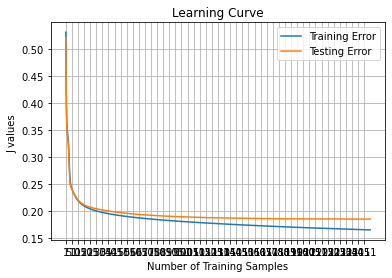

In [18]:
# Plot the learning curve
step_size = 50  # Adjust as needed
plot_learning_curve(training_errors, testing_errors, step_size)